# Emojifier Using Word Vector Representations

If you want to make your text messages more expressive then this emojifier app will help you do that. 

Rather than writing:
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"   

The emojifier can automatically turn this into:
>"Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️"


### Using Word Vectors to Improve Emoji Lookups
* In many emoji interfaces, you need to remember that ❤️  is the "heart" symbol rather than the "love" symbol. 
    * In other words, you'll have to remember to type "heart" to find the desired emoji, and typing "love" won't bring up that symbol.
* You can make a more flexible emoji interface by using word vectors!
* When using word vectors, you'll see that even if your training set explicitly relates only a few words to a particular emoji, your algorithm will be able to generalize and associate additional words in the test set to the same emoji.
    * This works even if those additional words don't even appear in the training set. 
    * This allows you to build an accurate classifier mapping from sentences to emojis, even using a small training set. 


In [1]:
!pip install emoji

In [ ]:
import numpy as np
import emoji
import csv
import matplotlib.pyplot as plt
import tensorflow as tf



%matplotlib inline

<a name='1'></a>
## 1 - Baseline Model: Emojifier-V1

<a name='1-1'></a>
### 1.1 - Dataset EMOJISET

Let's start by building a simple baseline classifier. 

You have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

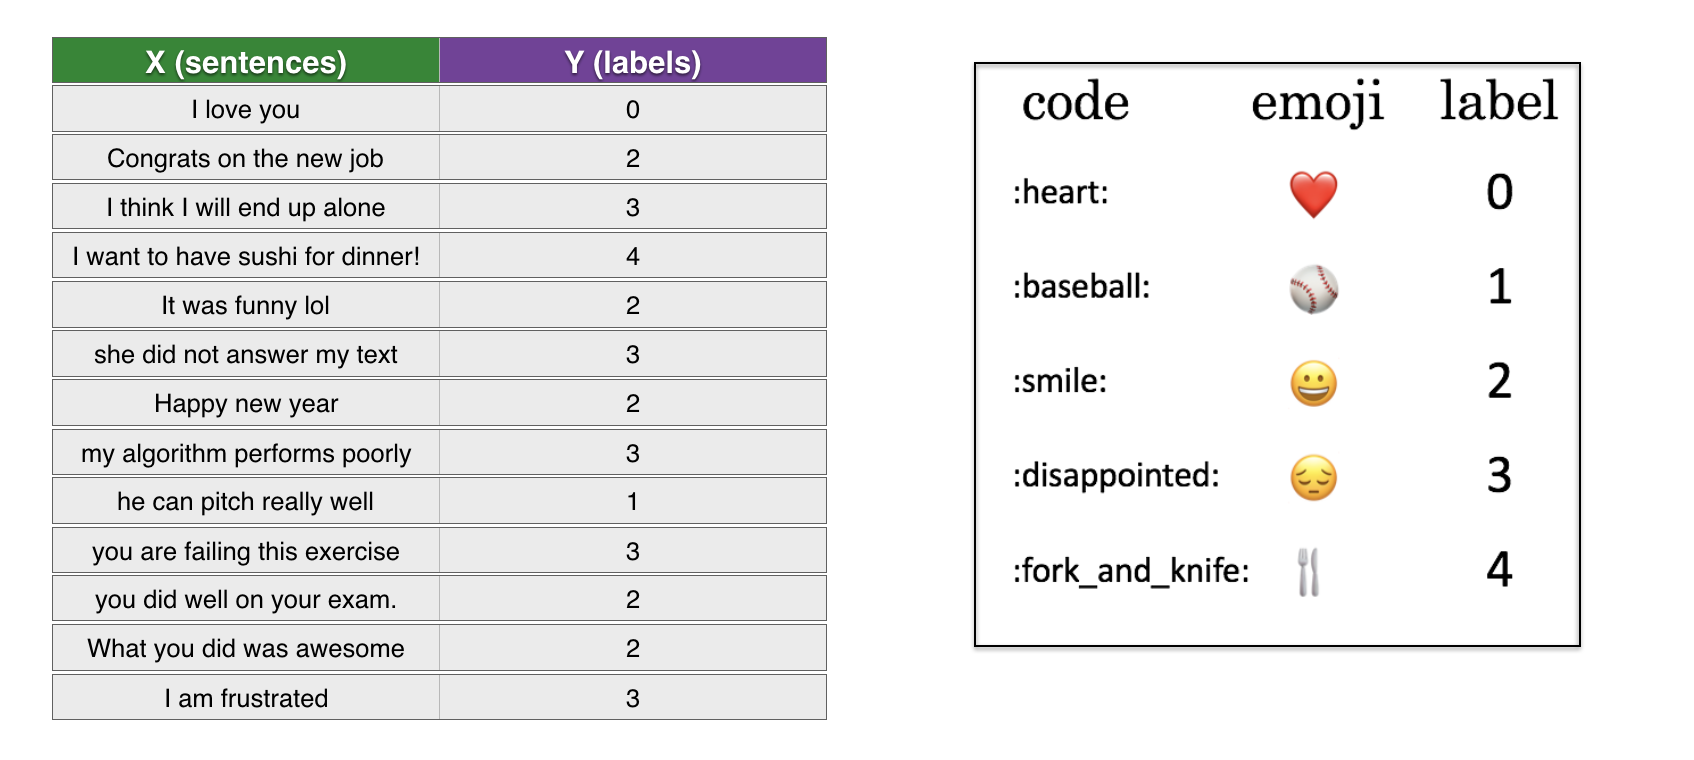

In [2]:
from IPython.display import Image
Image(filename='images/data_set.png',height=300,width=800)

<!--- <img src="images/data_set.png" style="width:700px;height:300px;"> 
-->
<caption><center><font color='purple'><b>Figure 1</b>: EMOJISET - a classification problem with 5 classes. A few examples of sentences are given here. </center></caption>

The dataset is split between training (127 examples) and testing (56 examples).

In [3]:
emoji_dictionary={0:"heart",1:"baseball",2:"smile",3:"disappointed",4:"fork_and_knife"}

In [4]:
#emoji library will convert labels to emoji 
for em in emoji_dictionary.values():
    print(emoji.emojize(f":{em}:",language='alias'))

❤️
⚾
😄
😞
🍴


In [5]:
def read_csv(file):
    phrases=[]
    labels=[]
    with open(file,'r') as csvData:
        data=csv.reader(csvData)
        for row in data:
            phrases.append(row[0].replace("\t",''))
            labels.append(row[1])

    X=np.asarray(phrases)
    Y=np.asarray(labels,dtype=int)

    return X,Y

In [6]:
def label_to_emoji(label):
    return emoji.emojize(f":{emoji_dictionary[label]}:",language='alias')

In [7]:
X_train,y_train=read_csv("data/train_emoji.csv")
X_test,y_test=read_csv("data/tesss.csv")

In [8]:
#Getting lenth of longest word
max_len=0
for phrase in X_train:
    for word in phrase.split():
        #print(word)
        if len(word)>max_len:
            max_len=len(word)

print(max_len)

15


In [9]:
for idx in range(10):
    print(X_train[idx],label_to_emoji(y_train[idx]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit 😞
congratulations on your acceptance 😄
The assignment is too long  😞
I want to go play ⚾


<a name='1-2'></a>
### 1.2 - Overview of the Emojifier-V1

WEe'll implement a baseline model called "Emojifier-v1".  

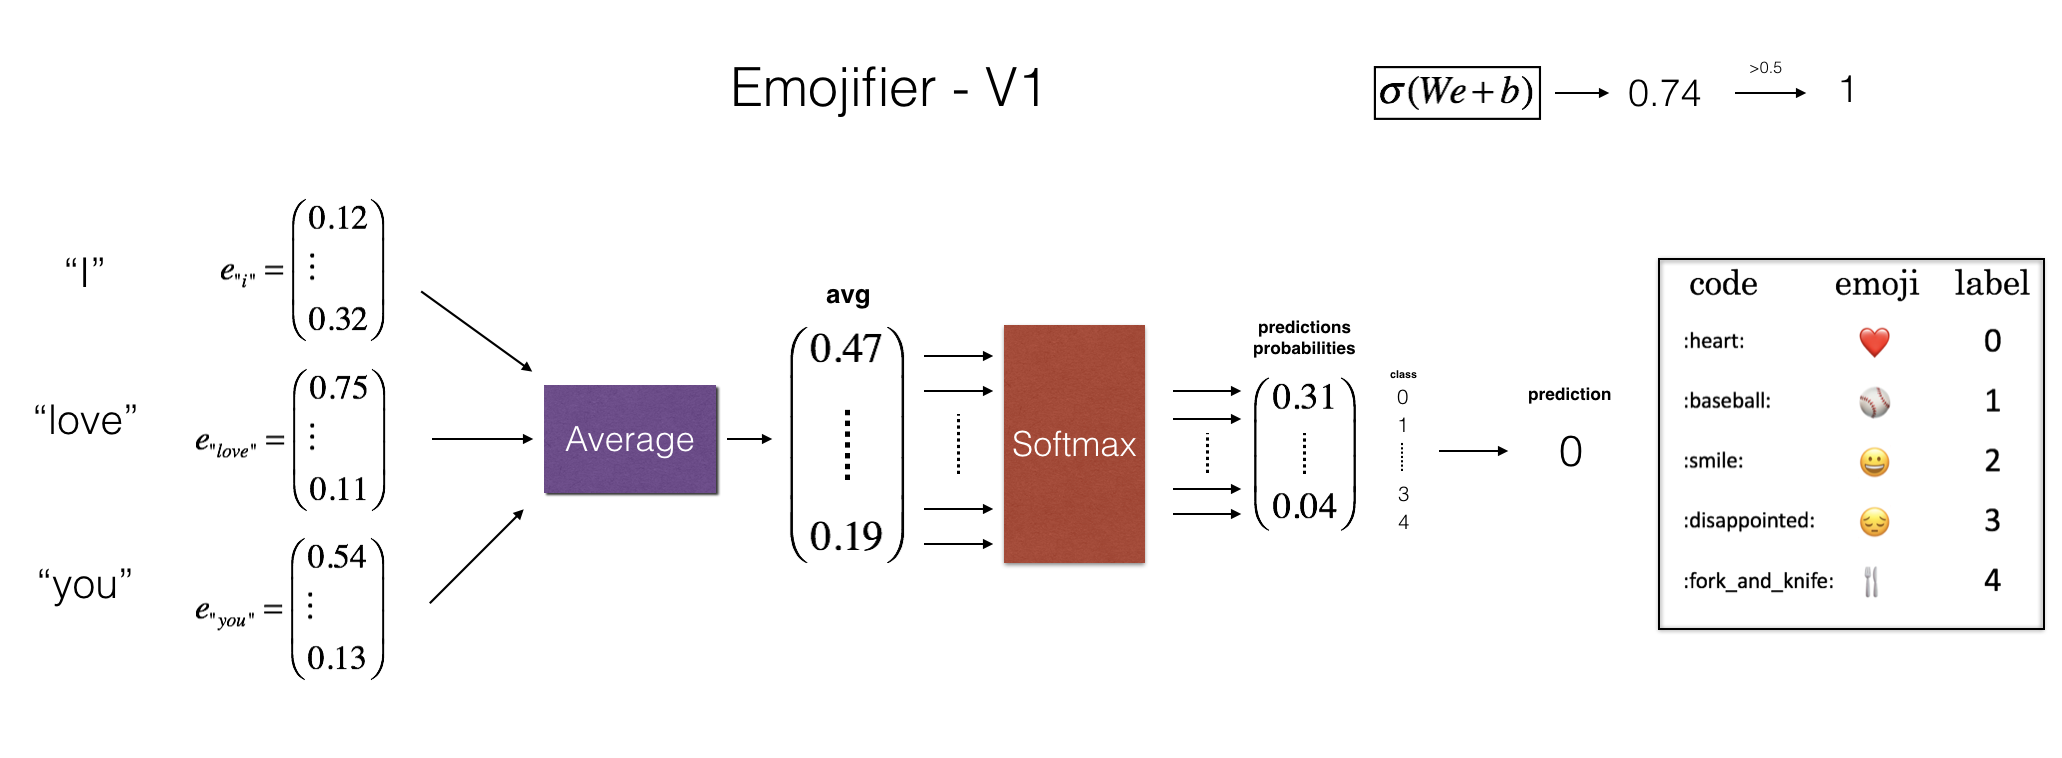

In [5]:
from IPython.display import Image
Image(filename='images/image_1.png',height=300,width=900)

<center>
<!--- <img src="images/image_1.png" style="width:900px;height:300px;">
-->
    <caption><center><font color='purple'><b>Figure 2</b>: Baseline model (Emojifier-V1).</center></caption>
</center></font>


#### Inputs and Outputs
* The input of the model is a string corresponding to a sentence (e.g. "I love you"). 
* The output will be a probability vector of shape (1,5), (indicating that there are 5 emojis to choose from).
* The (1,5) probability vector is passed to an argmax layer, which extracts the index of the emoji with the highest probability.

In [10]:
def convert_to_onehot(x,classes):
    '''
    converts to onhe hot encoded representation
    Arguments:
    x -- array
    classes -- no. of classes/labels
    
    Returns:
        One hot encoded array
    '''
    return np.eye(classes)[x.reshape(-1)]

In [11]:
y_train_oh=convert_to_onehot(y_train,5)
y_test_oh=convert_to_onehot(y_test,5)

In [12]:
print(y_train.shape,y_train_oh.shape)

(132,) (132, 5)


In [13]:
idx = 50
print(f"Sentence '{X_train[idx]}' has label index {y_train[idx]}, which is emoji {label_to_emoji(y_train[idx])}", )
print(f"Label index {y_train[idx]} in one-hot encoding format is {y_train_oh[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


In [14]:
def read_glove_vecs(file):
    words=set()
    word_to_vec_map={}
    with open(file,'r') as f:
        for line in f:
            l=line.strip().split()
            words.add(l[0])
            word_to_vec_map[l[0]]=np.asarray(l[1:],dtype=np.float64)
        
        
        word_to_index={}
        index_to_word={}
        for i,word in enumerate(sorted(words)):
            word_to_index[word]=i
            index_to_word[i]=word

    #return words
    return word_to_index,index_to_word,word_to_vec_map

In [15]:
word_to_index,index_to_word,word_to_vec_map=read_glove_vecs("data/glove.6B.50d.txt")

In [16]:
word = "cucumber"
idx = 289845
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113316
the 289845th word in the vocabulary is potatos


In [17]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    all_words=list(word_to_vec_map.keys())
    
    words=sentence.lower().split()
    
    count=0
    avg=np.zeros(np.array(word_to_vec_map[all_words[0]]).shape)
    
    for word in words:
        if word in all_words:
            avg+=word_to_vec_map[word]
            count+=1
            
    if count > 0:
        avg/=count
        
    return avg

In [18]:
def model(X, Y, word_to_vec_map,model=None, learning_rate = 0.01, num_iterations = 200):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    any_word=list(word_to_vec_map.keys())[0]
    
    m=len(Y)
    n_y=len(np.unique(Y)) #num of classes
    n_x=word_to_vec_map[any_word]
    
    X_avg=np.zeros((m,len(n_x)))
    
    for i in range(len(X)):
        X_avg[i]=sentence_to_avg(X[i], word_to_vec_map)
        
    y_oh=convert_to_onehot(Y,n_y)
    
    tf_model=tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=n_x.shape),
        tf.keras.layers.Dense(n_y,activation="softmax")
    ])
    
    tf_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])
    
    history=tf_model.fit(X_avg,y_oh,epochs=num_iterations,batch_size=1)
    
    #pred=tf_model(X_avg)
    #pred=np.argmax(tf.squeeze(pred),axis=1,keepdims=True)
    
    #w=tf_model.weights[1].numpy().T
    #b=tf_model.weights[1].numpy()
    
    #return pred,w,b
    return tf_model

In [19]:
def predict(X, Y, word_to_vec_map,model):
    """
    process X and Y and give predictions
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    model -- trained model
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)

    """
    any_word=list(word_to_vec_map.keys())[0]
    
    m=len(Y)
    n_y=len(np.unique(Y)) #num of classes
    n_x=word_to_vec_map[any_word]
    
    X_avg=np.zeros((m,len(n_x)))
    
    for i in range(len(X)):
        X_avg[i]=sentence_to_avg(X[i], word_to_vec_map)
        
    #y_oh=convert_to_onehot(Y,n_y)
    
   
    pred=model(X_avg)
    pred=np.argmax(tf.squeeze(pred),axis=1,keepdims=True)
    
    return pred

In [20]:
simple_model=model(X_train, y_train, word_to_vec_map)

Epoch 1/200


2023-01-26 05:50:56.692078: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-26 05:50:56.692136: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-26 05:50:56.692168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (18949f779602): /proc/driver/nvidia/version does not exist
2023-01-26 05:50:56.692523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


132/132 [==============================] - 1s 1ms/step - loss: 1.5059 - accuracy: 0.3561
Epoch 2/200
132/132 [==============================] - 0s 1ms/step - loss: 1.0535 - accuracy: 0.6061
Epoch 3/200
132/132 [==============================] - 0s 1ms/step - loss: 0.8632 - accuracy: 0.7045
Epoch 4/200
132/132 [==============================] - 0s 1ms/step - loss: 0.7411 - accuracy: 0.7500
Epoch 5/200
132/132 [==============================] - 0s 1ms/step - loss: 0.6689 - accuracy: 0.7727
Epoch 6/200
132/132 [==============================] - 0s 1ms/step - loss: 0.5836 - accuracy: 0.8030
Epoch 7/200
132/132 [==============================] - 0s 1ms/step - loss: 0.5616 - accuracy: 0.8333
Epoch 8/200
132/132 [==============================] - 0s 1ms/step - loss: 0.5060 - accuracy: 0.8485
Epoch 9/200
132/132 [==============================] - 0s 1ms/step - loss: 0.4740 - accuracy: 0.8712
Epoch 10/200
132/132 [==============================] - 0s 1ms/step - loss: 0.4485 - accuracy: 0.8333
E

In [21]:
y_test_pred=predict(X_test,y_test,word_to_vec_map,simple_model)
y_test_pred=np.squeeze(y_test_pred)

y_train_pred=predict(X_train,y_train,word_to_vec_map,simple_model)
y_train_pred=np.squeeze(y_train_pred)

In [22]:
print("Train Accuracy : ",np.mean(y_test==y_test_pred)*100)
print("Test Accuracy : ",np.mean(y_train==y_train_pred)*100)

Train Accuracy :  78.57142857142857
Test Accuracy :  99.24242424242425


In [23]:
def predict_single(sentence,model):
    
    X_avg=sentence_to_avg(sentence, word_to_vec_map)
    X_avg=X_avg.reshape((1,-1))
    pred=model(X_avg)
    pred=np.argmax(tf.squeeze(pred))
    return pred

In [24]:
label_to_emoji(int(predict_single("I love you",simple_model)))

'❤️'

In [25]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , word_to_vec_map,simple_model)

for i in range(len(X_my_sentences)):
    print(X_my_sentences[i],label_to_emoji(pred[i,0]))

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


* Word *adore* is not in training set but as it has a similar embedding as *love*, the algorithm has generalized correctly even to a word it has never seen before. 
* Words such as *heart*, *dear*, *beloved* or *adore* have embedding vectors similar to *love*. 

#### Word Ordering isn't Considered in this Model
* Note that the model doesn't get the following sentence correct:
>"not feeling happy" 

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy." 

#### Confusion Matrix
* Printing the confusion matrix can also help understand which classes are more difficult for your model. 
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).


In [26]:
# START SKIP FOR GRADING
print(y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(y_test, y_test_pred.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))

# END SKIP FOR GRADING

(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted   0  1   2   3  4  All
Actual                          
0           6  0   0   1  0    7
1           0  8   0   0  0    8
2           6  0  11   0  1   18
3           1  1   1  13  0   16
4           1  0   0   0  6    7
All        14  9  12  14  7   56


## 2 - Emojifier-V2: Using LSTMs in Keras 

We will build an LSTM model that takes word **sequences** as input! This model will be able to account for word ordering. 


In [27]:
import numpy as np
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)

<a name='2-1'></a>
### 2.1 - Model Overview

Here is the Emojifier-v2 we will implement:

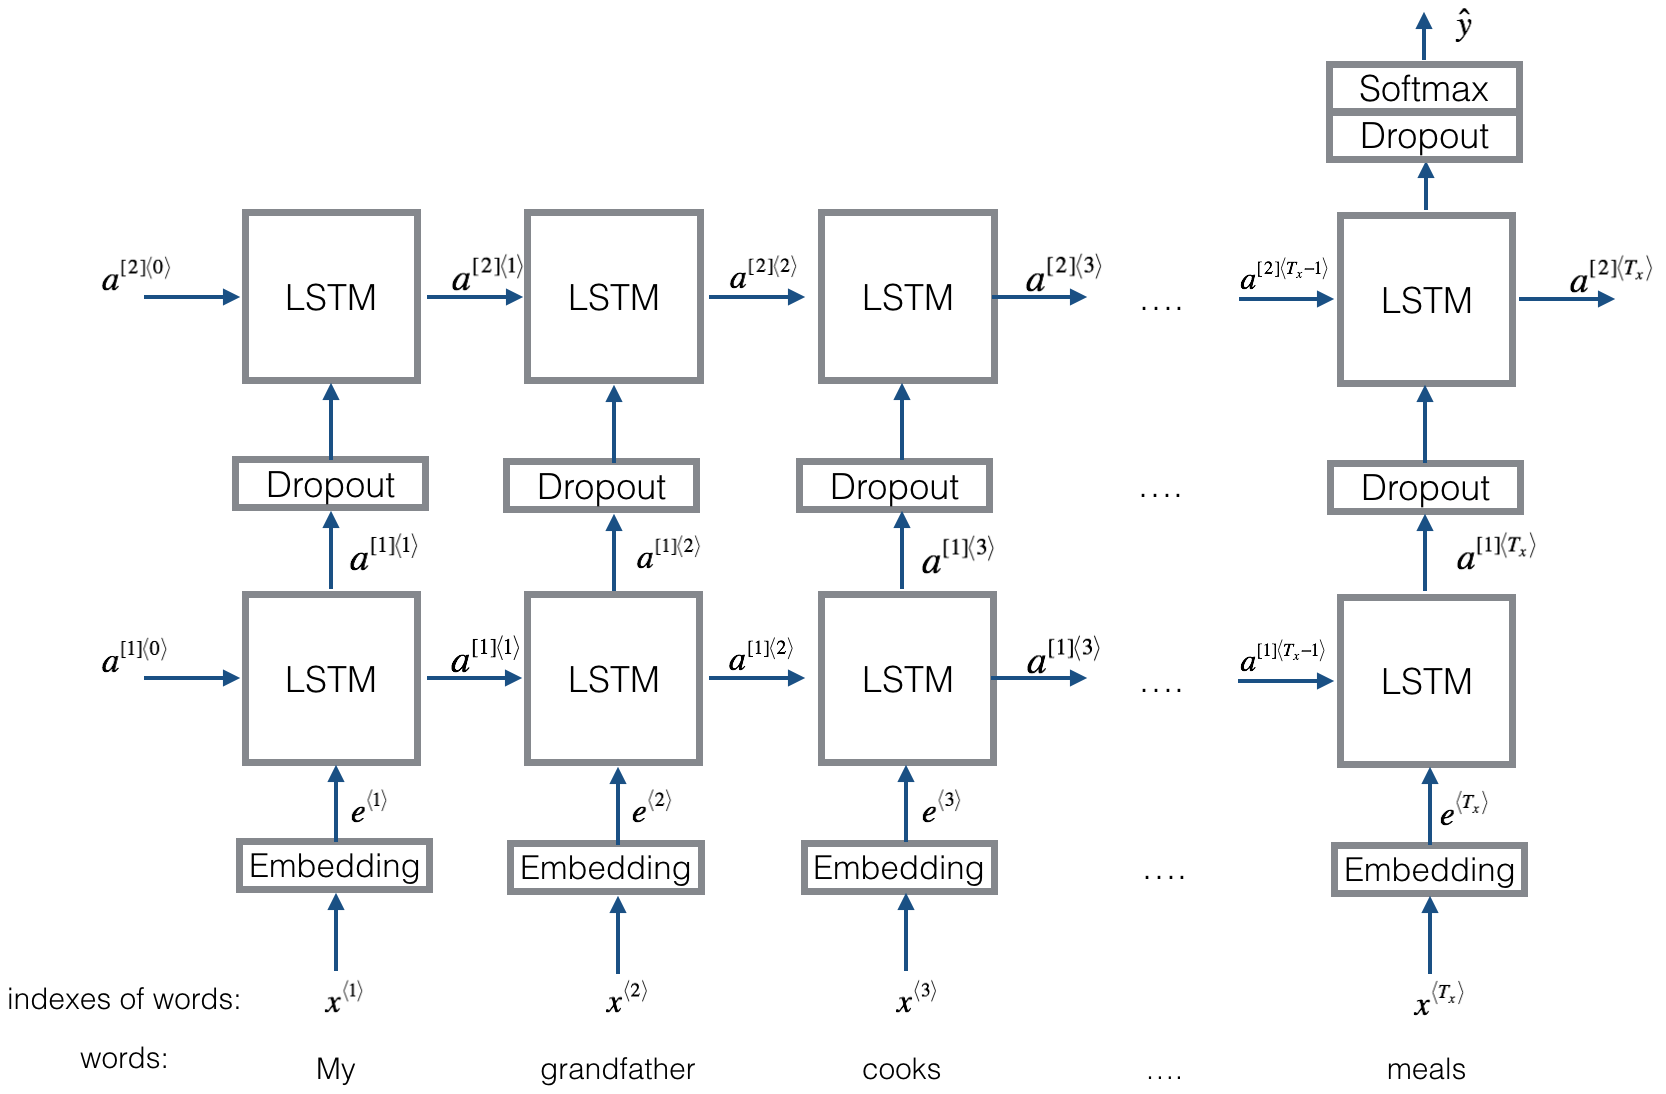

In [10]:
from IPython.display import Image
Image(filename='images/emojifier-v2.png',width=700,height=400)

<!--- <img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
-->
<caption><center><font color='purple'><b>Figure 3</b>: Emojifier-V2. A 2-layer LSTM sequence classifier. </center></caption>

### 2.3 - The Embedding Layer

In Keras, the embedding matrix is represented as a "layer."

* The embedding matrix maps word indices to embedding vectors.
    * The word indices are positive integers.
    * The embedding vectors are dense vectors of fixed size.
    * A "dense" vector is the opposite of a sparse vector. It means that most of its values are non-zero.  As a counter-example, a one-hot encoded vector is not "dense."
* The embedding matrix can be derived in two ways:
    * Training a model to derive the embeddings from scratch. 
    * Using a pretrained embedding.

In [ ]:
from IPython.display import Image
Image(filename='images/embedding1.png',width=700,height=250)


<img src="images/embedding1.png" style="width:700px;height:250px;">
<caption><center><font color='purple'><b>Figure 4</b>: Embedding layer</center></caption>

In [28]:

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m=len(X)
    X_indices=np.zeros((m,max_len))
    
    for i in range(m):
        sentence=X[i].strip().split()
        j=0
        for word in sentence:
            if word in word_to_index:
                X_indices[i,j]=word_to_index[word]
            j+=1
            
    return X_indices

In [29]:
X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=5)
print("X1 =", X1)
print("X1_indices =\n", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices =
 [[155344. 225121.      0.      0.      0.]
 [220929. 286374.  69713.      0.      0.]
 [151203. 192972. 302253. 151348. 394474.]]


In [40]:

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size=len(word_to_index)+1  # adding 1 to fit Keras embedding (requirement) , + 1 for unknown words 
    any_word=list(word_to_index.keys())[0]
    emb_dim=word_to_vec_map[any_word].shape[0]
    
    emb_matrix=np.zeros((vocab_size,emb_dim))
    
    for word,idx in word_to_index.items():
        emb_matrix[idx,:]=word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_size, emb_dim ,trainable = False)
    
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,))
    
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [41]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][1] =", embedding_layer.get_weights()[0][1][1])
print("Input_dim", embedding_layer.input_dim)
print("Output_dim",embedding_layer.output_dim)

weights[0][1][1] = 0.26952
Input_dim 400001
Output_dim 50


In [70]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    
    sentence_indices=Input(shape=input_shape,dtype='int32')
    
    embedding_layer=pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings=embedding_layer(sentence_indices)
    
    x=LSTM(128,return_sequences=True)(embeddings)
    
    x=Dropout(0.5)(x)
    
    x=LSTM(128,return_sequences=False)(x)
    
    x=Dropout(0.5)(x)
    
    x=Dense(5)(x)
    
    x=Activation('softmax')(x)
    
    model=Model(inputs=sentence_indices,outputs=x)
    
    return model

In [76]:
model = Emojify_V2((max_len,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 15)]              0         
                                                                 
 embedding_16 (Embedding)    (None, 15, 50)            20000050  
                                                                 
 lstm_22 (LSTM)              (None, 15, 128)           91648     
                                                                 
 dropout_22 (Dropout)        (None, 15, 128)           0         
                                                                 
 lstm_23 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 5)                 645

In [77]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

<a name='2-5'></a>
### 2.5 - Train the Model 

It's time to train your model! Your Emojifier-V2 `model` takes as input an array of shape (`m`, `max_len`) and outputs probability vectors of shape (`m`, `number of classes`). Thus, you have to convert X_train (array of sentences as strings) to X_train_indices (array of sentences as list of word indices), and Y_train (labels as indices) to Y_train_oh (labels as one-hot vectors).

In [78]:
X_train_indices = sentences_to_indices(X_train, word_to_index, max_len)
Y_train_oh = convert_to_one_hot(y_train,  5)

In [82]:
model.fit(X_train_indices, Y_train_oh, epochs = 80,batch_size = 32, shuffle=True)

Epoch 1/80
5/5 [==============================] - 0s 35ms/step - loss: 1.3686 - accuracy: 0.4242
Epoch 2/80
5/5 [==============================] - 0s 34ms/step - loss: 1.2903 - accuracy: 0.4848
Epoch 3/80
5/5 [==============================] - 0s 34ms/step - loss: 1.2768 - accuracy: 0.4394
Epoch 4/80
5/5 [==============================] - 0s 34ms/step - loss: 1.2706 - accuracy: 0.4924
Epoch 5/80
5/5 [==============================] - 0s 34ms/step - loss: 1.1615 - accuracy: 0.5000
Epoch 6/80
5/5 [==============================] - 0s 34ms/step - loss: 1.0876 - accuracy: 0.5455
Epoch 7/80
5/5 [==============================] - 0s 34ms/step - loss: 1.0673 - accuracy: 0.6061
Epoch 8/80
5/5 [==============================] - 0s 34ms/step - loss: 1.2937 - accuracy: 0.4697
Epoch 9/80
5/5 [==============================] - 0s 34ms/step - loss: 1.0985 - accuracy: 0.5152
Epoch 10/80
5/5 [==============================] - 0s 35ms/step - loss: 0.9077 - accuracy: 0.6364
Epoch 11/80
5/5 [============

In [94]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len )
Y_test_oh = convert_to_one_hot(y_test,5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

2/2 [==============================] - 0s 12ms/step - loss: 0.9891 - accuracy: 0.7857

Test accuracy =  0.7857142686843872


In [86]:
# This code allows you to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != y_test[i]):
        print('Expected emoji:'+ label_to_emoji(y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

2/2 [==============================] - 1s 12ms/step
Expected emoji:😄 prediction: he got a very nice raise❤️
Expected emoji:😞 prediction: work is hard😄
Expected emoji:😞 prediction: work is horrible😄
Expected emoji:😄 prediction: Congratulation for having a baby❤️
Expected emoji:🍴 prediction: any suggestions for dinner😄
Expected emoji:😄 prediction: you brighten my day❤️
Expected emoji:😞 prediction: she is a bully❤️
Expected emoji:❤️ prediction: My grandmother is the love of my life😄
Expected emoji:😞 prediction: My life is so boring😄
Expected emoji:😄 prediction: will you be my valentine❤️
Expected emoji:😞 prediction: go away⚾
Expected emoji:🍴 prediction: I did not have breakfast ❤️


In [93]:
# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(["congrats for promotion"])
X_test_indices = sentences_to_indices(x_test, word_to_index, max_len)
print(x_test[0] +' '+  label_to_emoji(np.argmax(model.predict(X_test_indices))))

1/1 [==============================] - 0s 28ms/step
congrats for promotion 😄


#### LSTM Version Accounts for Word Order
* The Emojify-V1 model did not "not feeling happy" correctly, but your implementation of Emojify-V2 got it right! 
    * If it didn't, be aware that Keras' outputs are slightly random each time, so this is probably why. 
* The current model still isn't very robust at understanding negation (such as "not happy")
    * This is because the training set is small and doesn't have a lot of examples of negation. 
    * If the training set were larger, the LSTM model would be much better than the Emojify-V1 model at understanding more complex sentences. 